In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

spark = SparkSession.builder.appName("SongRecommendationWithArtists").config("spark.executor.memory", "4g").config("spark.driver.memory", "4g").config("spark.executor.cores", "2").config("spark.driver.maxResultSize", "2g").config("spark.sql.shuffle.partitions", "200").getOrCreate()

# Load the dataset into a PySpark DataFrame
file_path = './tracks_features.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Attributes for recommendation
attributes = ["danceability", "energy", "liveness", "valence", "tempo"]

# Replace null values in all columns with 0
#df = df.select([when(col(c).isNull(), 0).otherwise(col(c)).alias(c) for c in df.columns])

# Replace nulls or non-numeric values and cast to double
for attr in attributes:
    df = df.withColumn(attr, when(col(attr).isNull(), 0.0).otherwise(col(attr).cast("double")))

df = df.fillna(0)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 16:42:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 16:42:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/07 16:42:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
from pyspark.sql.functions import col, sum

# Check for nulls in each column
null_counts = df.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in df.columns])

# Show the count of nulls per column
null_counts.show(truncate=False)

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|id |name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|0  |0   |1    |0       |0      |1         |0           |0          |0       |0           |0     |0  |0       |0   |0          |0           |0               |0       |0      |0    |0          |0             |0   |0           |
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

In [3]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: string (nullable = true)
 |-- disc_number: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: double (nullable = false)
 |-- energy: double (nullable = false)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: double (nullable = false)
 |-- valence: double (nullable = false)
 |-- tempo: double (nullable = false)
 |-- duration_ms: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- year: string (nullable = true)
 |-- release_date: string (nullable = true)



In [4]:
# Encode 'artists' using StringIndexer and OneHotEncoder
string_indexer = StringIndexer(inputCol="artists", outputCol="artist_index")
one_hot_encoder = OneHotEncoder(inputCol="artist_index", outputCol="artist_vector")


In [5]:
# Combine numerical attributes and the artist vector into a single feature vector
vector_assembler = VectorAssembler(inputCols=attributes + ["artist_vector"], outputCol="features")


In [6]:
df = string_indexer.fit(df).transform(df)
df = one_hot_encoder.fit(df).transform(df)
df = vector_assembler.transform(df)


# Define the KMeans model
kmeans = KMeans(k=100, seed=1, featuresCol="features", predictionCol="cluster")

# Train the model
model = kmeans.fit(df)

24/12/07 16:42:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/12/07 16:42:59 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:02 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:03 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:06 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:07 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:09 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:09 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:11 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 16:43:12 WARN DAGScheduler

In [6]:

# Define the KMeans model
kmeans = KMeans(k=100, seed=1, featuresCol="features", predictionCol="cluster")

# Create a pipeline
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder, vector_assembler, kmeans])

# Train the model
model = pipeline.fit(df)

24/12/07 15:37:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/12/07 15:37:04 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:06 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:07 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:10 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:11 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:12 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:13 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:15 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
24/12/07 15:37:16 WARN DAGScheduler

24/12/07 15:33:30 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:32 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:32 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:34 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:34 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:35 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:35 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:35 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:36 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
24/12/07 15:33:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/07 15:33:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/12/07 

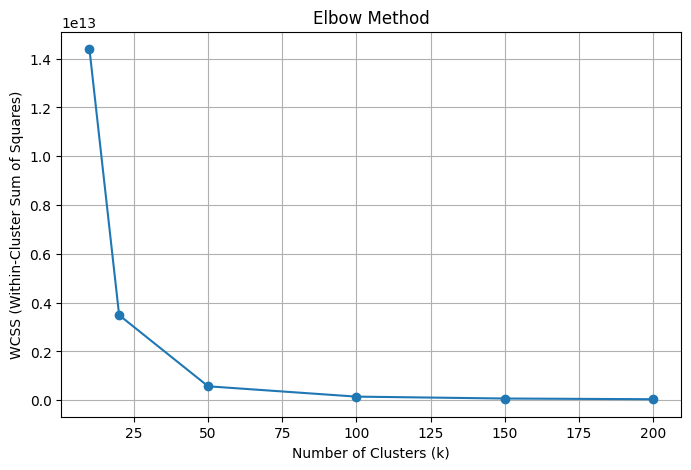

In [4]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans

# Ensure 'artist_index' is created
string_indexer = StringIndexer(inputCol="artists", outputCol="artist_index")
df = string_indexer.fit(df).transform(df)  # Add 'artist_index' column

# Ensure 'features' column is created
attributes = ["danceability", "energy", "liveness", "valence", "tempo"]
vector_assembler = VectorAssembler(inputCols=attributes + ["artist_index"], outputCol="features")
df = vector_assembler.transform(df)  # Add 'features' column

# List of k values to try
ks = [10, 20, 50, 100, 150, 200]  # Adjust as needed
costs = []

# Iterate through different k values and compute WCSS
for k in ks:
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(df)
    cost = model.summary.trainingCost  # WCSS
    costs.append(cost)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(ks, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.grid()
plt.show()

In [7]:
# Transform the dataset to assign clusters
df = model.transform(df)  # Adds 'cluster' column with predictions


In [1]:
df.printSchema()

NameError: name 'df' is not defined

In [8]:
df.show()

24/12/07 16:45:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/07 16:45:36 WARN DAGScheduler: Broadcasting large task binary with size 135.3 MiB


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+-------------------+------------------+---+-------------------+----+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+-----------+--------------+----+------------+------------+--------------------+--------------------+-------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|       danceability|            energy|key|           loudness|mode|         speechiness|        acousticness|    instrumentalness|           liveness|            valence|             tempo|duration_ms|time_signature|year|release_date|artist_index|       artist_vector|            features|cluster|
+--------------------+--------------------+--------------------+----------------

In [12]:
# Count the number of unique artist names
unique_artists_count = df.select("artists").distinct().count()

print(f"Number of unique artist names: {unique_artists_count}")

Number of unique artist names: 165254


In [9]:
# Define paths for saving model and data
model_path = "./model/kmeans_model"
preprocessed_data_path = "./model/preprocessed_data"

# Save the trained model
model.write().overwrite().save(model_path)

# Save the preprocessed data with cluster assignments
df.write.mode("overwrite").parquet(preprocessed_data_path)

24/12/07 16:38:17 WARN TaskSetManager: Stage 84 contains a task of very large size (13186 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 16:38:19 WARN DAGScheduler: Broadcasting large task binary with size 185.6 MiB
24/12/07 16:38:25 ERROR Executor: Exception in task 7.0 in stage 87.0 (TID 2555)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.math.BigInteger.<init>(BigInteger.java:576)
	at java.base/java.math.BigInteger.<init>(BigInteger.java:721)
	at scala.math.BigInt$.apply(BigInt.scala:80)
	at org.json4s.jackson.JValueDeserializer._deserialize$1(JValueDeserializer.scala:20)
	at org.json4s.jackson.JValueDeserializer._deserialize$1(JValueDeserializer.scala:48)
	at org.json4s.jackson.JValueDeserializer._deserialize$1(JValueDeserializer.scala:34)
	at org.json4s.jackson.JValueDeserializer._deserialize$1(JValueDeserializer.scala:48)
	at org.json4s.jackson.JValueDeserializer._deserialize$1(JValueDeserializer.scala:48)
	at org.json4s.jackson.JValueDeserializer.

Py4JError: An error occurred while calling o431.toString

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/karthik540/Documents/College/Sem_3/BigData/Project/Spotify Recommendation/.venv/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/karthik540/Documents/College/Sem_3/BigData/Project/Spotify Recommendation/.venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karthik540/Documents/College/Sem_3/BigData/Project/Spotify Recommendation/.venv/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while send

In [9]:

# Define the 5 given songs by their IDs
given_song_ids = ["12Cbou8Hl4yGGuTZlkLl60"]

# Get clusters for the given songs
given_songs = df.filter(col("id").isin(given_song_ids)).select("id", "cluster")

# Recommend songs from the same cluster for each given song
recommendations = {}
for row in given_songs.collect():
    song_id = row["id"]
    cluster_id = row["cluster"]
    
    # Get 5 songs from the same cluster, excluding the given song itself
    similar_songs = df.filter((col("cluster") == cluster_id) & (col("id") != song_id)) \
                      .select("name", "artists", "danceability", "energy", "liveness", "valence", "tempo") \
                      .limit(5)
    
    recommendations[song_id] = similar_songs.collect()

# Display recommendations
for song_id, recs in recommendations.items():
    print(f"\nRecommendations for Song ID {song_id}:")
    for row in recs:
        print(f"  Name: {row['name']}, Artists: {row['artists']}, "
              f"Danceability: {row['danceability']}, Energy: {row['energy']}, "
              f"Liveness: {row['liveness']}, Valence: {row['valence']}, Tempo: {row['tempo']}")

24/12/07 16:45:44 WARN DAGScheduler: Broadcasting large task binary with size 135.3 MiB



Recommendations for Song ID 12Cbou8Hl4yGGuTZlkLl60:
  Name: Man on a Mission, Artists: ['Daryl Hall & John Oates'], Danceability: 0.787, Energy: 0.903, Liveness: 0.10099999999999999, Valence: 0.9620000000000001, Tempo: 119.946
  Name: strange, Artists: ['Tori Amos'], Danceability: 0.5329999999999999, Energy: 0.319, Liveness: 0.11800000000000001, Valence: 0.19699999999999998, Tempo: 119.475
  Name: Waste of Mind, Artists: ['zebrahead'], Danceability: 0.602, Energy: 0.9109999999999999, Liveness: 0.0514, Valence: 0.848, Tempo: 120.178
  Name: Wish I May, Artists: ['Ani DiFranco'], Danceability: 0.804, Energy: 0.47200000000000003, Liveness: 0.369, Valence: 0.5870000000000001, Tempo: 120.376
  Name: Done Wrong, Artists: ['Ani DiFranco'], Danceability: 0.5589999999999999, Energy: 0.33899999999999997, Liveness: 0.27399999999999997, Valence: 0.0805, Tempo: 119.661


24/12/07 16:45:45 WARN DAGScheduler: Broadcasting large task binary with size 135.3 MiB
